In [18]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.integrate import simps

In [19]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [20]:
features = pd.DataFrame.from_csv("../../data/global_acc_features_df.csv")


In [164]:
def lpf(data,t,cutoff,order):# Filter requirements.
    fs = len(data) / (max(t)-min(t))      # sample rate, Hz
    
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
#     w, h = freqz(b, a, worN=8000)
#     plt.subplot(2, 1, 1)
#     plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
#     plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
#     plt.axvline(cutoff, color='k')
#     plt.xlim(0, 0.5*fs)
#     plt.title("Lowpass Filter Frequency Response")
#     plt.xlabel('Frequency [Hz]')
#     plt.grid()


    # Demonstrate the use of the filter.
    # First make some data to be filtered.
    T = max(t)-min(t)           # seconds
    n = len(data) # total number of samples
    t = np.linspace(0, T, n, endpoint=False)
    # "Noisy" data.  We want to recover the 1.2 Hz signal from this.


    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, fs, order)

#     plt.subplot(2, 1, 2)
#     plt.plot(t, data_6, 'b-', label='data')
#     plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
#     plt.xlabel('Time [sec]')
#     plt.grid()
#     plt.legend()

#     plt.subplots_adjust(hspace=0.35)
#     plt.show()
    
    return y

In [174]:
def from_acc_get_velocity(acc,t):
    v_3 = []
    for i in range(len(t)):
        v_3.append(simps(0.8*acc[:i+1], x=t[:i+1]))
    return v_3

def from_velocity_get_distance(v,t):
    d = []
    for i in range(len(t)):
        d.append(simps(v[:i+1], x=t[:i+1]))
    return d

def correct_velocity_drift(v_0):
    d = v_0[-1] / len(v_0)
    for i in range(len(v_0)):
        v_0[i] = v_0[i] - d*i
    return v_0

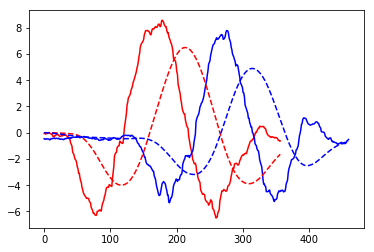

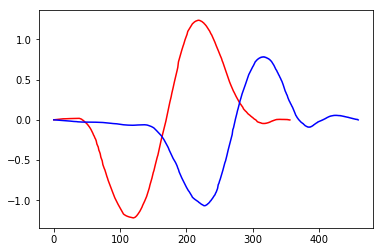

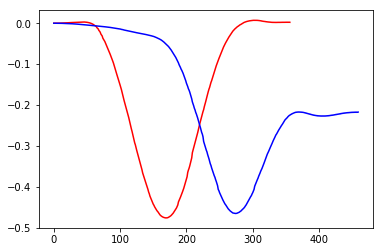

In [188]:
g_0 = features[(features.TagName == 'Tag0') & (features.tester_id == 3.0)]
g_6 = features[(features.TagName == 'Tag6') & (features.tester_id == 3.0)]

t_0 = g_0.unix_timestamp.values
t_6 = g_6.unix_timestamp.values

data_0 = g_0.global_acc3.values
data_6 = g_6.global_acc3.values

order = 2
cutoff = 1.0
lpt_acc_0 = lpf(data_0,t_0,cutoff,order)
lpt_acc_6 = lpf(data_6,t_6,cutoff,order)

acc_0 = lpt_acc_0
acc_6 = lpt_acc_6

acc_0 = data_0
acc_6 = data_6

v_0= from_acc_get_velocity(acc_0, t_0)
v_6= from_acc_get_velocity(acc_6, t_6)

v_0_cor = correct_velocity_drift(v_0)
v_6_cor = correct_velocity_drift(v_6)

d_0_cor = from_velocity_get_distance(v_0_cor,t_0)
d_6_cor = from_velocity_get_distance(v_6_cor,t_6)

plt.plot(data_0,color='r')
plt.plot(data_6,color='b')
plt.plot(lpt_acc_0,'r--')
plt.plot(lpt_acc_6,'b--')
plt.show()
plt.plot(v_0_cor,'r')
plt.plot(v_6_cor,'b')
plt.show()
plt.plot(d_0_cor,'r')
plt.plot(d_6_cor,'b')
plt.show()

In [183]:
def lowpassfilter(data):
    fc = 0.1
    b = 0.08
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    new_signal = np.convolve(data, sinc_func)
    return new_signal

In [ ]:
def shrink_array(array,size):
    
    ratio = float(len(array)) / float(size+1)
    res = []
    for i in range(size):
        res.append(np.mean(array[math.floor(i*ratio):math.ceil((i+1.0)*ratio)], axis = 0))
    return np.array(res)

In [4]:
def moving_ave(data):
    N = 20
    cumsum, moving_aves = [0], []

    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
            
    return moving_aves